In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 6.7})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial',size=8)


In [2]:
exit_intensity_data = rf"./data/intensities_exit.h5"
data_intensities_exit =AM.read_hdf5_as_dict(exit_intensity_data)
data_intensities_exit.keys()
# data_field_intensities key containes the flux


dict_keys(['chi', 'data_field_intensities', 'data_field_intensities_2', 'f', 'sample', 'size', 'x'])

In [3]:
data_intensities_exit["data_field_intensities"].shape

(13, 16, 5, 957, 150)

In [4]:
data_intensities_exit["size"]

array([ 0.5,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. ,
       11. , 12. , 13. , 14. , 15. ])

In [5]:
data_exit = data_intensities_exit["data_field_intensities"]
value = np.mean(data_exit,axis=2)[8,9,:,:] #chi_0.37 and size 0.9
# value[value/np.max(value) < 1e-10] = 0
value_normalized = value/np.max(value,axis=(0))
value_normalized[np.isnan(value_normalized)] = 0

In [6]:
# #gap data from Luis 
# luis_gap_data_path = rf"H:\phd stuff\tidy3d\Notebooks\2D SHU Project\20250623 MPB Bands\Luis Data\band_structure_stats\20251218_bandgaps_chi_0p30_0p40_tolerance_0.02.h5"
# gap_data_luis = AM.read_hdf5_as_dict(luis_gap_data_path)

low_nDOS_boundaries=np.array([[0.297,0.297,0.299,0.303,0.308,0.315,0.323,0.333,0.338,0.343,0.354, 0.375, 0.380,0.380,0.384, 0.387, 0.390,0.394,0.398,0.401,0.404,0.407 ],
                         [0.40 , 0.39 , 0.38, 0.37,0.36,0.35,0.34,0.33,0.32,0.31, 0.30, 0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37, 0.38 , 0.39, 0.40]])

# PBG_boundaries=np.array([[0.297, 0.297 ,0.299, 0.3221,0.356,0.3679,0.3650,0.3659,0.3632,  0.3643, 0.3675,0.3677,0.3767,0.3833,0.3869, 0.401, 0.404, 0.407 ],
#                          [0.40 , 0.39 , 0.38, 0.37,0.36,0.35,0.34,0.33,0.32,0.32,0.33,0.34,0.35,0.36,0.37, 0.38 , 0.39, 0.40]])

PBG_boundaries=np.array([[0.297, 0.297 ,0.299, 0.3221,0.356,0.3679,0.3767,0.3833,0.3869, 0.401, 0.404, 0.407 ],
                         [0.40 , 0.39 , 0.38, 0.37,0.36,0.35,0.35,0.36,0.37, 0.38 , 0.39, 0.40]])

half = low_nDOS_boundaries[0].size // 2

band_edge_array =(np.c_[low_nDOS_boundaries[0, :half], low_nDOS_boundaries[0, :half-1:-1]])[::-1]

gap_limit = band_edge_array[7]  # for chi=0.37

In [7]:
# Define the colors: Blue -> White -> Yellow -> Green -> Red
colors = [
          (1, 1, 1),  # White
          (0, 0, 1),  # Blue
          (1, 1, 0),  # Yellow
          (0, 1, 0),  # Green
          (1, 0, 0), #Red
          (0, 0, 0), # Black
          ]  

# Create a custom colormap
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)


In [8]:
def calculate_IPR(intensity_array,x1):
    values = intensity_array
    integral_1 = scipy.integrate.simpson(values**2, x=x1, axis=0)
    integral_2 = scipy.integrate.simpson(values, x=x1,axis=0)**2

    return integral_1/integral_2

def calculate_sigma(intensity_array, x1):
    x1 = np.asarray(x1)
    values = intensity_array
     # Reshape x1 to broadcast over columns (axis=1)
    x1 = x1[:, np.newaxis]  

    norm = scipy.integrate.trapezoid(values, x=x1[:, 0], axis=0)
    mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
    mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
    sigma = np.sqrt(mean_sq - mean**2)
    return 1/(2.45*sigma)
#Calculate IPR for this sample 

ipr_values = calculate_sigma(value_normalized,data_intensities_exit["x"])

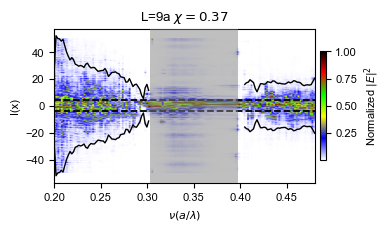

In [9]:
from matplotlib.colors import LogNorm
f = data_intensities_exit["f"]/td.C_0
fig, ax = plt.subplots(figsize=(3.5,2))
im=plt.imshow(value_normalized, 
                  vmin = np.min(value_normalized), vmax = np.max(value_normalized), 
                  # norm=LogNorm(vmin=np.min(value_normalized), vmax=np.max(value_normalized)),
                  extent =[np.min(f),np.max(f), -50,50], 
                  aspect='auto', cmap=cmap) 
# Add colorbar for reference
cbar = fig.colorbar(im, ax=ax, label=rf"$a/ \xi$",orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(rf"Normalized $|E|^2$"
)
gap_color = (0.85, 0.85, 0.85)  

ax.axhline(4, linestyle='--', color="black", linewidth=1.3, alpha=1.0)
ax.axhline(-4, linestyle='--', color="black", linewidth=1.3, alpha=1.0)
ax.axvspan(gap_limit[0], gap_limit[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=1000, clip_on=False)
w=2
smoothed_ipr = np.convolve(1/ipr_values, np.ones(w)/w, mode='same')
mask_ipr = (f > gap_limit[0]) & (f < gap_limit[1]+0.005)
smoothed_ipr[mask_ipr] = np.nan
ax.plot(f, smoothed_ipr, color='black', linewidth=1.0)
ax.plot(f, -smoothed_ipr, color='black', linewidth=1.0)
plt.xlabel(rf"$\nu(a/\lambda)$")
plt.ylabel(rf"I(x)")
plt.title(rf"L=9a $\chi=0.37$")

# plt.savefig(rf'./figures/20251211_Exit_Intensity_Chi0.37_Size_{9}.pdf', dpi=300, bbox_inches='tight')
plt.show()

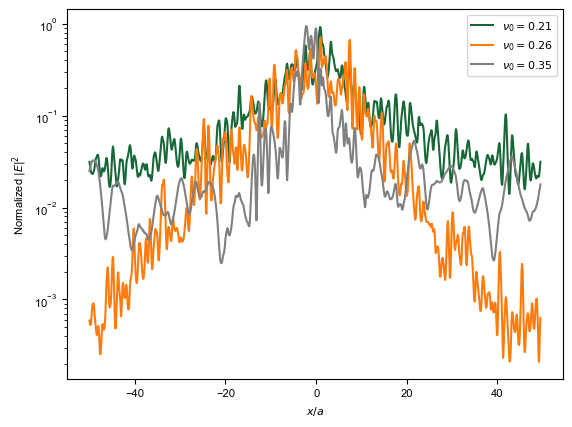

In [13]:
window=0
# nu=0.21
diffusion = AM.moving_average(np.mean(value_normalized[:,np.argmin(np.abs(f-0.20)):np.argmin(np.abs(f-0.23))],axis=1),w=window)
# nu=0.26
localization = AM.moving_average(np.mean(value_normalized[:,np.argmin(np.abs(f-0.25)):np.argmin(np.abs(f-0.27))],axis=1),w=window)
# nu=0.35
gap_intensity = AM.moving_average(np.mean(value_normalized[:,np.argmin(np.abs(f-0.34)):np.argmin(np.abs(f-0.36))],axis=1),w=window)
# gap_intensity[gap_intensity<1e-2] = np.nan

x_values = AM.moving_average(data_intensities_exit["x"],w=window)


plt.plot(x_values, diffusion, label=r"$\nu_0 = 0.21$")
plt.plot(x_values, localization, label=r"$\nu_0 = 0.26$")
plt.plot(x_values, gap_intensity, label=r"$\nu_0 = 0.35$",color="gray")
plt.ylabel(rf"Normalized $|E|^2$")
plt.xlabel(rf"$x/a$")
plt.legend()
plt.yscale("log")
plt.show()